# Demonstration of subsampling feature dimensions

In [1]:
import pandas as pd
import openensembles as oe
import matplotlib.pyplot as plt

## Lu (2005) mRNA 
# Lu, J., Getz, G., Miska, E. a, Alvarez-Saavedra, E., Lamb, J., Peck, D., … Golub, T. R. (2005). MicroRNA expression profiles classify human cancers. Nature, 435(7043), 834–838. https://doi.org/10.1038/nature03702
# Originally, data was clustering 89 cell lines in 14,546 dimensions, which is fraught with 
# problems with dimensionality. Instead, here, we will randomly subsample a smaller number of dimensions many times
fileName = '../data/Common_Affy.txt'
raw_mRNA89 = pd.read_csv(fileName, sep='\t',skiprows=2)
raw_mRNA89.set_index('Name', inplace=True)
raw_mRNA89.drop('Description', axis=1, inplace=True)
raw_mRNA89_filtered=raw_mRNA89[~(raw_mRNA89<7.25).all(axis=1)]

D = raw_mRNA89_filtered.transpose() #final data frame

In [2]:
#setup oe.data object
d = oe.data(D, list(D.columns))

#transform, take the zscore so that mean values don't dominate clustering
d.transform('parent', 'zscore', 'zscore')


In [3]:
# select a random susbampling of n_features to cluster num_repeats times
n_features = 100
num_repeats = 2000
names = []
for i in range(0, num_repeats):
    name = 'zscore_'+str(i)
    names.append(name)
    d.transform('zscore', 'random_subsample', name, num_to_sample=n_features)
    
    

In [4]:
# Cluster all subsamples using agglomerative clustering
c = oe.cluster(d)
K=15
for name in names:
    c.cluster(name, 'agglomerative', name, K)

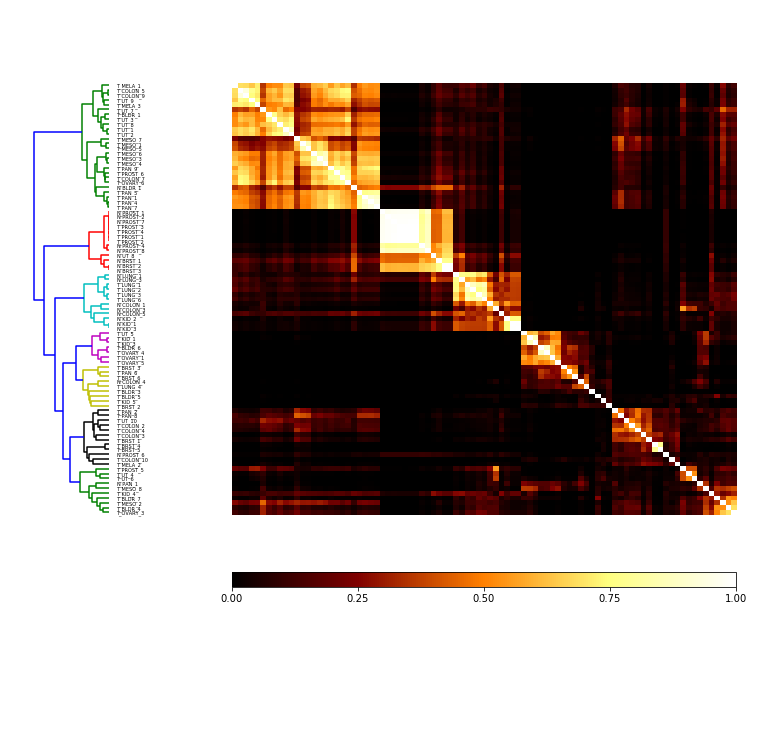

In [5]:
comat = c.co_occurrence_matrix('zscore')
fig = comat.plot(linkage='ward', threshold=1.5)
fig.savefig('comat.eps') 
plt.show()

## How sensitive is subsampling to global vs. subsample z-scoring

In [6]:
#setup a fresh oe.data object from D
dRz = oe.data(D, list(D.columns))


In [7]:
# select a random susbampling of n_features to cluster num_repeats times
# apply the zscore after random sample is taken
n_features = 100
num_repeats = 2000
names = []
for i in range(0, num_repeats):
    name_base = 'random_'+str(i)
    
    dRz.transform('parent', 'random_subsample', name_base, num_to_sample=n_features)
    name = 'zscore_' + name_base
    dRz.transform(name_base, 'zscore', name)
    names.append(name)
    

In [8]:
# Cluster all subsamples using agglomerative clustering
cRz = oe.cluster(dRz)
K=15
for name in names:
    cRz.cluster(name, 'agglomerative', name, K)

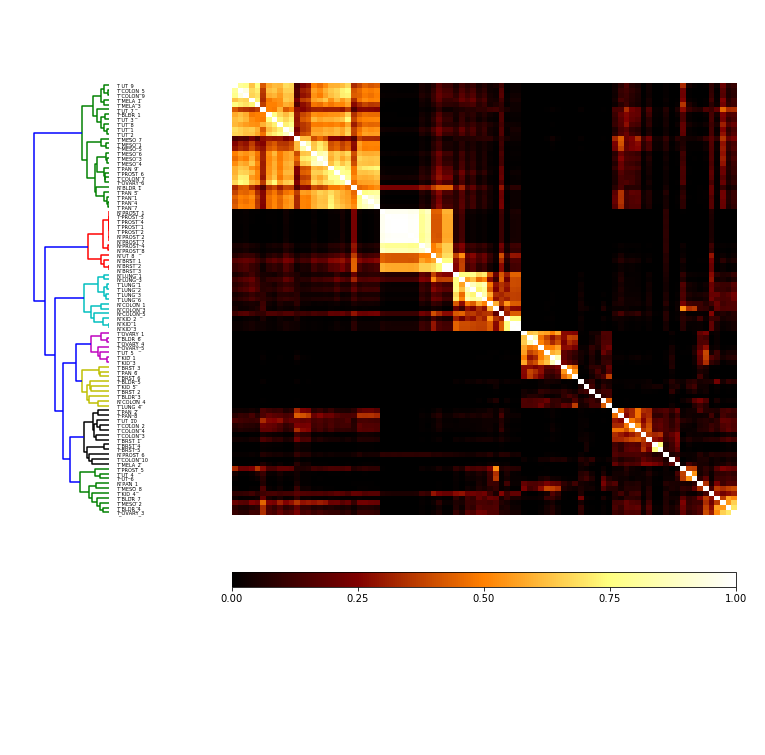

In [9]:
comat = cRz.co_occurrence_matrix('parent')
fig = comat.plot(linkage='ward', threshold=1.5)
fig.savefig('comat_subsampleFirst.eps')
plt.show()

## Finish the ensembles using the co-occurrence matrix

In [10]:
#cut the co-occurrence matrices and compare across the two methods of clustering
c_ComatCut = c.finish_co_occ_linkage(threshold=1.5, linkage='ward')
cMV = c.finish_majority_vote(threshold=0.5)

cRz_ComatCut = cRz.finish_co_occ_linkage(threshold=1.5, linkage='ward')
cRz_cMV = cRz.finish_majority_vote(threshold=0.5)

In [11]:
transDictList = c_ComatCut.merge([cMV, cRz_ComatCut, cRz_cMV])
transDictList

[{'majority_vote': 'majority_vote'},
 {'co_occ_linkage': 'co_occ_linkage_2'},
 {'majority_vote': 'majority_vote_3'}]

In [12]:
c_ComatCut.labels

{'co_occ_linkage': array([3, 3, 5, 3, 6, 6, 6, 1, 1, 1, 6, 7, 1, 6, 1, 1, 5, 1, 6, 1, 3, 3, 3,
        4, 4, 7, 5, 1, 1, 5, 7, 5, 4, 7, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 7, 1,
        4, 7, 4, 4, 1, 2, 1, 1, 1, 7, 4, 7, 1, 1, 1, 6, 3, 3, 3, 3, 3, 5, 3,
        1, 7, 1, 1, 1, 1, 1, 7, 1, 6, 1, 2, 2, 2, 6, 5, 5, 6, 6, 5], dtype=int32),
 'co_occ_linkage_2': array([3, 3, 5, 3, 6, 6, 6, 1, 1, 1, 6, 7, 1, 6, 1, 1, 5, 1, 6, 1, 3, 3, 3,
        4, 4, 7, 5, 1, 1, 5, 7, 5, 4, 7, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 7, 1,
        4, 7, 4, 4, 1, 2, 1, 1, 1, 7, 4, 7, 1, 1, 1, 6, 3, 3, 3, 3, 3, 5, 3,
        1, 7, 1, 1, 1, 1, 1, 7, 1, 6, 1, 2, 2, 2, 6, 5, 5, 6, 6, 5], dtype=int32),
 'majority_vote': array([ 1,  1,  2,  3,  4,  5,  4,  6,  6,  6,  7,  8,  6,  9,  6,  6, 10,
         6, 11,  6,  1,  1,  1, 12, 12, 13, 14,  6,  6, 15, 16, 17, 12, 16,
         1,  1,  1, 18,  1,  1,  1,  1,  1,  1,  1,  6, 12, 16, 12, 12,  6,
         1,  6,  6,  6, 19, 12, 19,  6,  6,  6,  4,  1,  1,  1,  1,  1, 20,
         1,  

In [13]:
MI = c_ComatCut.MI(MI_type='normalized')
MI.matrix

,co_occ_linkage,majority_vote,co_occ_linkage_2,majority_vote_3
co_occ_linkage,1,0.783985,1,0.780372
majority_vote,0.783985,1,0.783985,0.995392
co_occ_linkage_2,1,0.783985,1,0.780372
majority_vote_3,0.780372,0.995392,0.780372,1


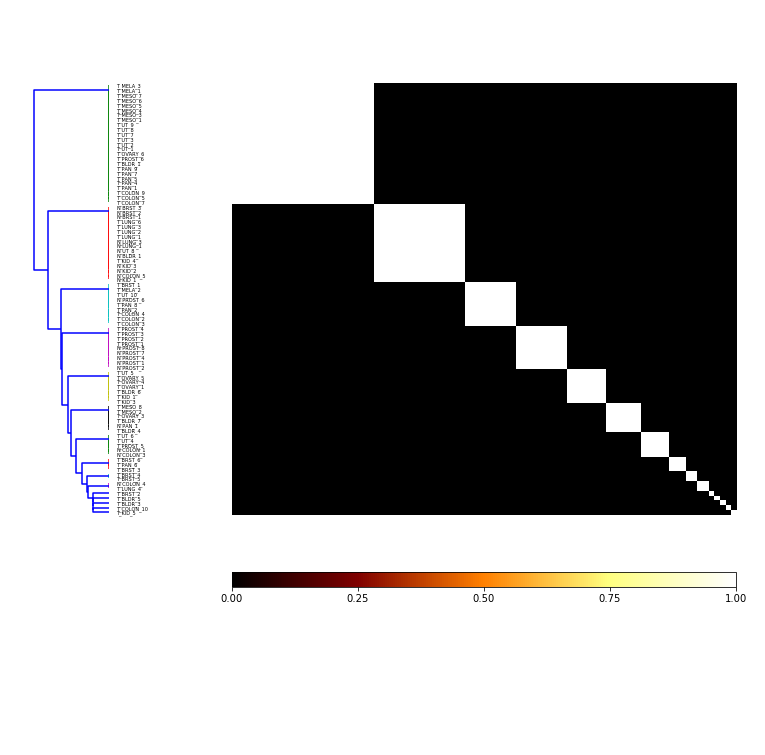

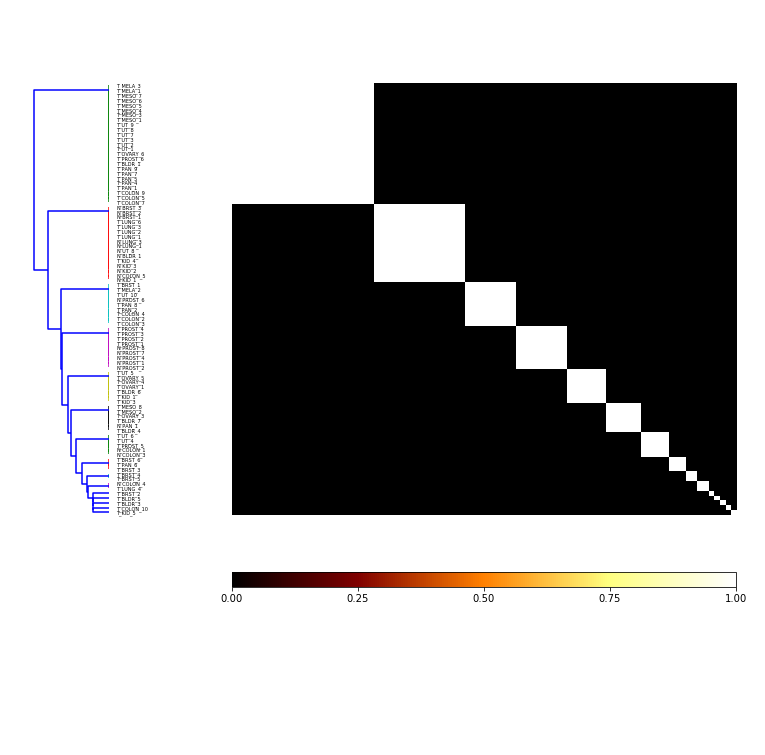

In [15]:
#Cluster the data in the original dimensionality for comparison
c_orig = oe.cluster(d)
c_orig.cluster('zscore', 'agglomerative', 'aggl_all', K)
comat_all = c_orig.co_occurrence_matrix('zscore')
fig = comat_all.plot(linkage='ward')
fig.savefig('comat_all.eps')
plt.show()